# load the packages and functions

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%run /home/mmurakami/crios_backups/ASTE_270/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# load the grid

In [4]:
# define basin we want
path = "/home/mmurakami/crios_backups/ASTE_270/offline_binning/sample_images/"

In [5]:
# read one basin or whole ASTE
whole = True
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()
mask = ~np.isnan(mymsk)

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
# if whole:
#     mask = (mymsk < 5) | (mymsk==6) 
# else:
mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
# test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [6]:
mymsk3 = np.tile(mymsk[np.newaxis,:,:],(nz,1,1)) * mygrid['hFacC']
mymsk3.shape

(50, 1350, 270)

# timesteps

In [8]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

# the following will need to be modified if we look at multiple time steps
# dt = datetimes[1]-datetimes[0]   # days
# dt = dt.total_seconds()

# ocean and ice
AB_gT=0
AB_gS=0

In [45]:
allyears = np.arange(2003,2018,1)

(12,)

In [23]:
# for one year
# tsstr = tsstr[:6]
# datetimes = datetimes[:6]
datetimes.shape

(12,)

In [24]:
# 'datetimes' is a list of datetime objects
dt = [(datetimes[i+1] - datetimes[i]).total_seconds() for i in range(len(datetimes) - 1)]
dt = np.array(dt)
dt.shape

(11,)

# load the files for a time series of FW content

In [46]:
# loop through the years to create the timeseries
alldatetimes = np.array([])
FW_times = np.array([])

for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the volume values

    # for mass tendency (m^3/s) - time is not yet included in this block
    file_name = 'budg2d_snap_set1'
    
    # assuming all files are structured the same
    meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
    # try to read this with rec
    fldlist = np.array(meta_budg2d_snap_set1['fldList'])
    varnames = np.array(['ETAN'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    
    # set for all months
    vol = np.full((len(tsstr),nz, ny, nx),np.nan)
    ETANS = np.full((len(tsstr),ny,nx),np.nan)
    print("volume allocation shape",vol.shape)
    
    for t in range(len(tsstr)):
        t1 = tsstr[t]
        read = [int(t1)]
    
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])
    
        # choose by basin
        ETAN = np.reshape(ETAN,(ny,nx)) #* wetmask[0,:,:]
    
        # ocean
        if debug:
            print(read,its[0],its[1]) # these iteration numbers should be the same as read
    
        # 3D, with rStar:
        tmpvol = np.zeros((nz, ny, nx))
        if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
            tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
            if myparms['useRFWF'] == 0:
                tmpvol[0, :, :] = np.zeros((ny, nx))
        else:    # 4/22 look at this one
            if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
                tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
                tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
            else:
                tmp2 = drf3d / mk3D_mod(DD, tmp1)
    
            # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
            tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) #* mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3
    
        vol[t,:,:,:] = tmpvol
    
    print(vol.shape)


    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))
    
    # divide first two and second two by dt
    theta = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    dthetadt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
    salt = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    dsaltdt = np.full((int(len(tsstr)-1),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        theta[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']
        salt[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']
    
    for i in range(len(tsstr)-1):
        dthetadt[i,:,:,:] = (THETADR[i,:,:,:]/DRF3d/mygrid['hFacC'] - THETADR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]
        dsaltdt[i,:,:,:] = (SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC'] - SALTDR[i-1,:,:,:]/DRF3d/mygrid['hFacC'])/dt[i-1]


    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    sref = 34.8#41.05      # PSU
    filter = drf3d.copy() * mygrid['hFacC']
    filter[filter >= 254] = np.nan
    filter[filter < 254] = 1
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to 254 m based on the np.where(np.cumsum(mygrid['DRF'])<254)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than 254 m
        saltnorm = 1-(salt[i]/sref)
        FWvol = vol[i] * (1-salt[i]/sref)   # m^3 * 1
        FWvol /=  RAC3    # m
        FWvol = FWvol[:19]
        
        # vertically integrate
        FWcontent[i] = np.nansum(FWvol,axis=0) * mymsk          # summing in depth for the upper layer, m

    ####
    # append to big list

    for i in range(len(datetimes)):
        FW_times = np.append(FW_times,np.nansum(FWcontent[i]))
        alldatetimes = np.append(alldatetimes,datetimes[i])

2003
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2004
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2005
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2006
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2007
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2008
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2009
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2010
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2011
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2012
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2013
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2014
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2015
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2016
volume allocation shape (12, 50, 1350, 270)
(12, 50, 1350, 270)
2017
volume allocation shape (12, 

In [65]:
# do the masking and get a singular value
# alldatetimes[-60:]

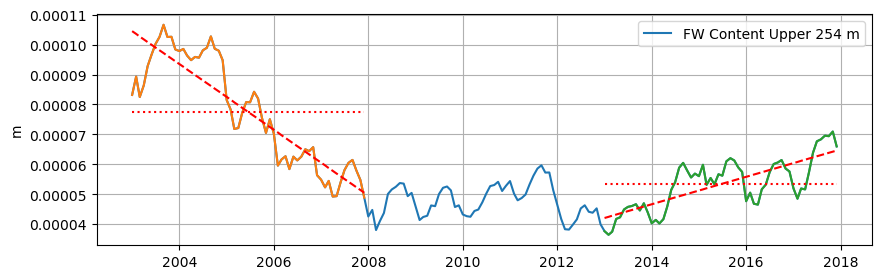

In [66]:
# now we can look at a time series of each of the J terms for salt at this given cell in a given year

fig = plt.figure(figsize=(10,3))

plt.subplots_adjust(hspace=0.6)  # bigger hspace -- more vertical space

ax = plt.subplot(111)
ax.plot(alldatetimes,FW_times,label='FW Content Upper 254 m')
# ax.set_title("FW")
ax.set_ylabel("m")
ax.grid()
ax.legend()

# add two trendlines to this fig
coefficients = np.polyfit(np.arange(len(alldatetimes[:60])), FW_times[:60], 1)
trendline = np.polyval(coefficients, np.arange(len(alldatetimes[:60])))
ax.plot(alldatetimes[:60], FW_times[:60], label="mean FW, m")
ax.plot(alldatetimes[:60], trendline, label="Trendline", color='red', linestyle='--')
avgline = np.nanmean(FW_times[:60])
avgline = np.full(60,avgline)
ax.plot(alldatetimes[:60], avgline, color='red', linestyle=':')

# do the same for 2013-17
coefficients = np.polyfit(np.arange(len(alldatetimes[-60:])), FW_times[-60:], 1)
trendline = np.polyval(coefficients, np.arange(len(alldatetimes[-60:])))
ax.plot(alldatetimes[-60:], FW_times[-60:], label="mean FW, m")
ax.plot(alldatetimes[-60:], trendline, label="Trendline", color='red', linestyle='--')
avgline = np.nanmean(FW_times[-60:])
avgline = np.full(60,avgline)
ax.plot(alldatetimes[-60:], avgline, color='red', linestyle=':')

plt.savefig(path + "FWtimeseries.png",dpi=300)

In [18]:
# we will want to load only one file at a time so that we don't overload the memory
# load these files
    # Ocean temperature, air temperature, sensible heat are all things to look at
    # Sea ice

In [19]:
# let's do this for sea ice alone so we can look here
# we'll set the datetimes each time so that we can look each time without loading all the files
# tsstr

In [ ]:
# FIX NAMES! THESE ARE NOT MEDIAN!!!

In [ ]:
# can do for sensible heat flux given from the atmosphere: "EXFhs from exf_zflux_set1"
# note this is not the total heat RECEIVED by the ocean